# Processing SST2 NEXAFS

## Imports

In [70]:
## Imports
import pathlib
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Loading raw sst2 nexafs data

In [71]:
# Define paths
propPath = pathlib.Path('/nsls2/data/sst/proposals/2023-2/pass-311130')
peyPath = propPath.joinpath('0723sst1nexafsdata')
outPath = propPath.joinpath('processed_data')


In [89]:
# Load first sample into DataArray -> Dataset
DAs = []
for f in sorted(list(peyPath.glob('*PEY1*'))):
    with f.open(mode='r') as file:
        lines = file.readlines()

    theta = int(lines[13].split('/')[1][-2:])
    sample_id = f.name.split('_')[0][2:]
    # columns = lines[17].split()

    d = np.loadtxt(f, skiprows=18)
    pey_d = np.vstack((d[:,0], d[:,3])).T
    
    DA = xr.DataArray(data = pey_d[:,1],
                      dims = ['Energy'],
                      coords = {'Energy': pey_d[:,0]})
    DA = DA.assign_coords({'Theta':theta}).expand_dims({'Theta':1})
    
    DAs.append(DA)

energies = np.round(DAs[0].Energy.values, 2)
for i, DA in enumerate(DAs):
    DAs[i] = DA.interp({'Energy': energies})
    
DA = xr.concat(DAs, dim='Theta').sortby('Theta')

DS = DA.to_dataset(name=sample_id)

In [90]:
# Load remaining samples into existing Dataset
for sample in ['PEY2', 'PEY3', 'PEY4', 'PEY5', 'PEY8']:
    DAs = []
    for f in sorted(list(peyPath.glob(f'*{sample}*'))):
        with f.open(mode='r') as file:
            lines = file.readlines()

        theta = int(lines[13].split('/')[1][-2:])
        sample_id = f.name.split('_')[0][2:]
        # columns = lines[17].split()

        d = np.loadtxt(f, skiprows=18)
        pey_d = np.vstack((d[:,0], d[:,3])).T

        DA = xr.DataArray(data = pey_d[:,1],
                          dims = ['Energy'],
                          coords = {'Energy': pey_d[:,0]})
        DA = DA.assign_coords({'Theta':theta}).expand_dims({'Theta':1})

        DAs.append(DA)

    for i, DA in enumerate(DAs):
        DAs[i] = DA.interp({'Energy': energies})
        
    DA = xr.concat(DAs, dim='Theta').sortby('Theta')
    DS[sample_id] = DA
    
DS = DS.assign_coords({'cos_sq_theta': (np.cos(np.radians(DS.Theta))**2)})

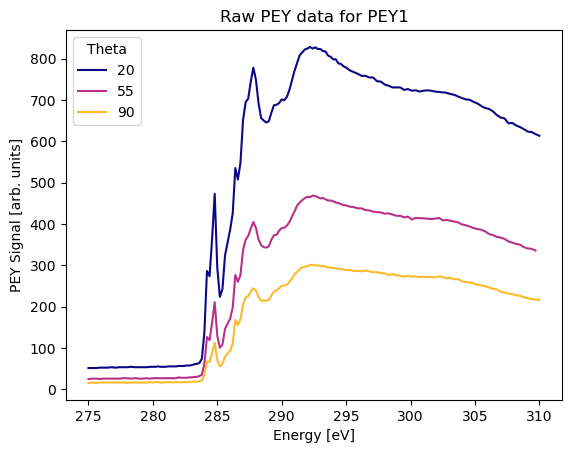

In [83]:
sample = 'PEY1'

colors = cmap(np.linspace(0,0.85,len(DS.Theta)))

fig, ax = plt.subplots()
for i, Theta in enumerate(DS.Theta):
    DS[sample].sel(Theta=Theta).plot.line(ax=ax, color=colors[i], label=int(Theta))

ax.set(title=f'Raw PEY data for {sample}', ylabel='PEY Signal [arb. units]', xlabel='Energy [eV]')
ax.legend(title='Theta')
# fig.savefig(outPath.joinpath('pey_nexafs', f'raw_{sample}.png'), dpi=120)
plt.show()
plt.close('all')

In [92]:
DA = DS['PEY1']

In [98]:
DA.sel(Energy=slice(275, 280))

<xarray.DataArray 'PEY1' (Theta: 3, Energy: 18)>
array([[51.2       , 51.2       , 51.20332226, 52.2       , 52.2       ,
        52.2       , 53.19667774, 52.2       , 53.2       , 53.2       ,
        53.20333333, 54.19668874, 53.20331126, 53.2       , 53.2       ,
        53.20334448, 54.2       , 54.2       ],
       [24.60662252, 25.6       , 25.59667774, 24.6       , 25.6       ,
        25.6       , 25.6       , 25.6       , 25.6       , 26.6       ,
        26.6       , 25.60333333, 26.6       , 25.6       , 25.6       ,
        26.6       , 25.6049505 , 26.5950495 ],
       [15.20332226, 16.2       , 15.2       , 16.19667774, 16.2       ,
        16.2       , 16.2       , 16.2       , 16.2       , 16.2       ,
        15.2       , 16.2       , 16.2       , 16.2       , 16.2       ,
        16.20334448, 17.19009901, 16.2       ]])
Coordinates:
  * Theta         (Theta) int64 20 55 90
  * Energy        (Energy) float64 275.0 275.3 275.6 275.9 ... 279.5 279.8 280.0
    cos_sq_theta  (Theta) float64 0.883 0.329 3.749e-33